## Street Lanes Finder - Detecting Street Lanes for Self-Driving Cars 🚗
**Author:** [Greg Surma](https://towardsdatascience.com/@gsurma)<br/>
**Original article:** [towardsdatascience.com](https://towardsdatascience.com/street-lanes-finder-detecting-street-lanes-for-self-driving-cars-fe069ec5a22d)

In today’s article, we are going to use basic **Computer Vision** techniques to approach the street lanes detection problem which is crucial for self-driving cars. By the end of this article, you will be able to perform real-time lane detection with **Python** and **OpenCV**.

![](car.gif)

## 

Let’s start with defining our problem.

Given an image of the road, we would like to detect street lanes on it.



Firstly, we should import some useful libraries and create basic functions

In [ ]:
!apt update && apt install -y python3-opencv
!pip install opencv-python

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease



2 packages can be upgraded. Run 'apt list --upgradable' to see them.



python3-opencv is already the newest version (3.2.0+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import cv2
import numpy as np
import os
import subprocess
import glob
from matplotlib import pyplot as plt

INPUT_FOLDER = "./input/"
OUTPUT_FOLDER = "./output/"
TEST_IMAGE = "test_image.jpg"
TEST_VIDEO = "test_video.mov"
DEBUG = False

def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()

### Load the original image

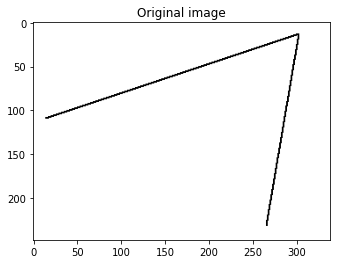

In [ ]:
# original_image = cv2.imread(INPUT_FOLDER + TEST_IMAGE)
original_image = cv2.imread('two_lines.png')
plot_image(original_image, 'Original image')

### Grayscale

## 

The first step of our pipeline is an image conversion from color to grayscale. We do it because in our case color values don’t hold any valuable information so to make further processing simpler and faster, we convert from three channels to one.

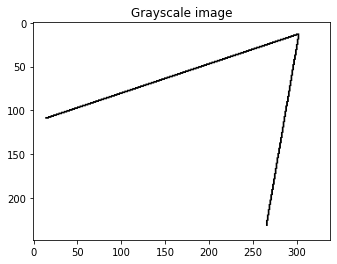

In [ ]:
# test_image = cv2.imread(INPUT_FOLDER + TEST_IMAGE)
test_image = cv2.imread('two_lines.png')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
plot_image(test_image, 'Grayscale image')
     

### Blur

### 

Then, to make our image smoother and less noisy, we apply a gentle Gaussian Blur.

Gaussian Blur works by calculating every pixel’s value as a weighted average of the surrounding pixels.

![](blur.jpeg)

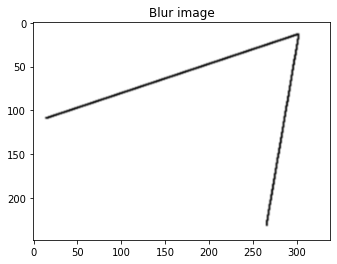

In [ ]:
test_image = cv2.GaussianBlur(test_image, (3,3),0)
plot_image(test_image, 'Blur image')

### Canny (Edge Detection)

### 

This is where the fun part begins. Now having a smooth grayscale image, we need to detect edges within it.

FYI, it’s called ‘canny’ because it was invented by [John Canny](https://en.wikipedia.org/wiki/John_Canny?source=post_page---------------------------).

Without going into too many details, the core part of the canny edge detector is based on scanning the image and calculating derivatives (gradients) of neighboring pixel values. The higher the gradient, the more likely it is an edge.

![An Example of a High Gradient Area](screenshot.png)

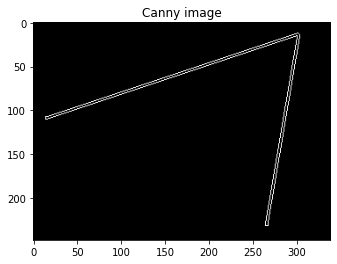

In [ ]:
test_image = cv2.Canny(test_image, 100, 150)
plot_image(test_image, 'Canny image')

### Region of Interest

### 

Now, having our edges detected, we can clearly see where our street lanes are, but besides that, we can also see other edges that are redundant. In order to get rid of them, we should mask our image to a specific region that’s called a **Region of Interest (ROI)**. Defining proper ROI is highly dependant on the camera calibration and its frame i.e what part of the road is visible.

In [ ]:
def roi(image):
    top_padding = 0
    bottom_padding = 0 # Front bumper compensation
    height = image.shape[0]
    width = image.shape[1]
    # FYI, below values are highly dependant on the camera calibration i.e what part of the road is actually being captured
    bottom_left = [0, height-bottom_padding]
    bottom_right = [width, height-bottom_padding]
    top_right = [width*1/3, height*1/3 + top_padding]
    top_left = [width*2/3, height*1/3 + top_padding]
    vertices = [np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.int32)]
    mask = np.zeros_like(image)  
    cv2.fillPoly(mask, vertices, 255)
    plot_image(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

### This is the defined mask where the white color shows ROI

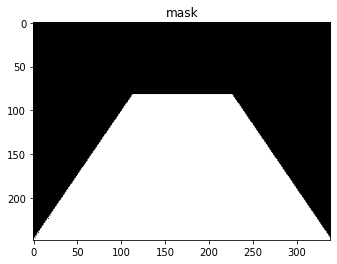

In [ ]:
roi_image = roi(test_image)

### this is canny image with a masked region of interest.

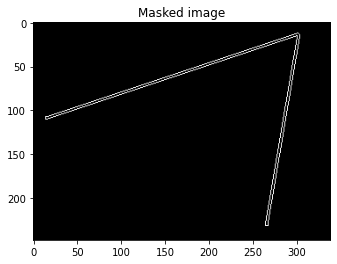

In [ ]:
plot_image(test_image, "Masked image")

### Hough Lines

### 

Now we have well defined lines that show where our street lanes are located. However, presenting them on the screen wouldn’t look appealing as they are noisy andflickery. In order to visualize them as single lines, we need to perform hough lines transformation.

1. Firstly, let’s detect all lines. We define a line as [x1,y1,x2,y2] where (x1, y1) is its start and (x2, y2) is its end.
2. Having our lines localized, we can calculate their slopes to determine whether they are right or left ones.
3. Then we need to average lines and derive single left and right line.
4. Ultimately, we can draw our final lines.

In [ ]:
def averaged_lines(image, lines):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    right = merge_lines(image, right_lines)
    return left, right

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        lines = averaged_lines(image, lines)
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
        plot_image(lines_image, "lines")
    return lines_image

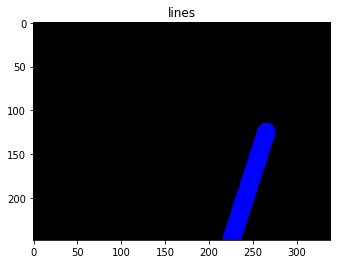

In [ ]:
hough_lines_image = hough_lines(test_image, 0.9, np.pi/180, 100, 100, 50)

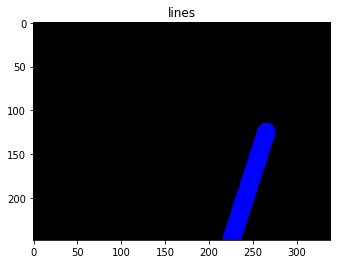

In [ ]:
hough_lines_image_test = hough_lines(test_image, 0.9, np.pi/180, 100, 100, 50)

### Image Overlay

### 

Finally, we need to overlay our input image with derived lines.

In [ ]:
def combine_images(image, initial_image, α=0.9, β=1.0, λ=0.0):
    combined_image = cv2.addWeighted(initial_image, α, image, β, λ)
    plot_image(combined_image, "combined")
    return combined_image

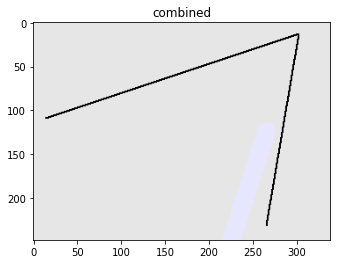

In [ ]:
final_image = combine_images(hough_lines_image, original_image)

### Real-Time Detection

### 

Having a pipeline that can detect lines for a single frame, we can run it real-time on a video stream performing detections on every frame. Unfortunately, we need better hardware for it.

![](car.gif)

## What’s Next?

### 

In this project, we’ve learned how to use basic **Computer Vision** techniques for real-life problems. Even though our results look very promising, street lanes detector is far from perfection and it might fail in some cases. That is why in the next part we are going to use Deep Learning approach (**Holistically-Nested Edge Detection**) to achieve better accuracy and more reliable detector. Stay tuned!

## 

Questions? Comments? Feel free to leave your feedback in the comments section or contact me directly at [https://gsurma.github.io](https://gsurma.github.io/?source=post_page---------------------------).

And don’t forget to 👏 if you enjoyed this article 🙂.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=67551570-9d71-4aed-9c87-2895f744897d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>